In [1]:
import warnings 
warnings.filterwarnings("ignore")

import sys
sys.dont_write_bytecode = True

In [2]:
import pandas as pd
import numpy as np
import json

from algorithms.clustering import hierarchical, kmeans , dbscan
from algorithms.associate_rule_mining import apriori, fpgrowth
from algorithms.forecasting import forecasting

import utils.clustering as clustering_utils
import utils.forecasting as forecasting_utils
import utils.comparison as comparison_utils

In [3]:
ecommerce_df = pd.read_csv("./data/e-commerce-data.csv", encoding= 'unicode_escape')

In [4]:
clustering_df = clustering_utils.preprocess(ecommerce_df)
clustering_data   = clustering_utils.get_data(clustering_df)

kmeans_model = kmeans.KMeans(n_clusters = 4)
kmeans_labels = kmeans_model.get_labels(clustering_data)

dbscan_model = dbscan.DBSCAN(eps=0.15, min_samples=15)
dbscan_labels = dbscan_model.get_labels(clustering_data)

hierarchical_model = hierarchical.HierarchicalClustering(n_clusters= 4)
hierarchical_labels = hierarchical_model.get_labels(clustering_data)

Total number of outliers is: 434


In [5]:
print(len(kmeans_labels), len(set(kmeans_labels)))
print(len(dbscan_labels), len(set(dbscan_labels)))
print(len(hierarchical_labels), len(set(hierarchical_labels)))

3904 4
3904 4
3904 4


In [6]:
customer_clusters_kmeans, customer_clusters_dbscan, customer_clusters_hierarchical = clustering_df, clustering_df, clustering_df
customer_clusters_kmeans['Cluster'] = kmeans_labels
customer_clusters_dbscan['Cluster'] = dbscan_labels
customer_clusters_hierarchical['Cluster'] = hierarchical_labels

In [7]:
customer_clusters = comparison_utils.get_best_clusters(ecommerce_df, customer_clusters_kmeans, customer_clusters_dbscan, customer_clusters_hierarchical)

best cluster by kmeans


In [9]:
# Create Apriori model and get rules
apriori_model = apriori.Apriori()
associate_rules_apriori = apriori_model.get_associate_rules(ecommerce_df, customer_clusters)

# Create FP-Growth model and get rules
fp_growth_model = fpgrowth.FPGrowth()   # <-- exact class name
associate_rules_fp_growth = fp_growth_model.get_associate_rules(ecommerce_df, customer_clusters)

# Compare both and get the best rules
associate_rules = comparison_utils.get_best_associate_rules(
    associate_rules_apriori,
    associate_rules_fp_growth
)


best rules by fpgrowth


In [10]:
associate_rules.to_csv("associate_rules.csv", index=False)

In [11]:
prediction_df = forecasting_utils.prediction_preprocess(ecommerce_df)
predictions_model = forecasting.Predictions()
predictions_model.get_associate_ruls(prediction_df)
prediction_df = predictions_model.get_predictions(ecommerce_df, prediction_df)

                                                              StockCode
InvoiceNo CustomerID                                                   
536365    17850.0     [84406B, 84029G, 85123A, 71053, 84029E, 21730,...
536366    17850.0                                        [22633, 22632]
536367    13047.0     [22748, 84969, 22623, 84879, 21754, 48187, 226...
536368    13047.0                          [22914, 22960, 22913, 22912]
536369    13047.0                                               [21756]
Number of rules generated :  8298
Dimensions of the association table are :  (8298, 3)
                                   basket next_product     proba
272   {22916, 22917, 22919, 22921, 22920}      {22918}  0.992481
496          {22916, 22921, 22917, 22919}      {22918}  0.985915
384          {22918, 22917, 22921, 22920}      {22916}  0.985612
382          {22916, 22921, 22917, 22920}      {22918}  0.985612
305          {22916, 22921, 22919, 22920}      {22918}  0.985294
169          {22921

In [12]:
prediction_df.to_csv("prediction.csv",index=False)

In [13]:
prediction_df = pd.read_csv("data/prediction.csv")
prediction_df['Customer basket'] = prediction_df['Customer basket'].apply(lambda x: eval(x))

In [14]:
price_add_by_date = forecasting_utils.get_price_add_by_date(ecommerce_df, prediction_df)

In [15]:
with open("price_add_by_date.json", "w") as outfile:
    json.dump(price_add_by_date, outfile)

In [16]:
with open('data/price_add_by_date.json') as json_file:
    price_add_by_date = json.load(json_file)

              TotalPrice
Date                    
2010-12-01  48310.229948
2010-12-02  49553.174830
2010-12-03  24927.688146
2010-12-05  34346.363768
2010-12-06  33427.236192


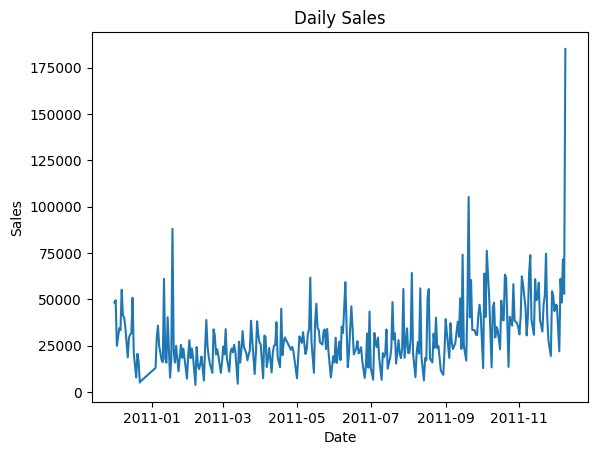

In [17]:
sales_by_date = forecasting_utils.time_series_preprocess(ecommerce_df, price_add_by_date)
print(sales_by_date.head())
forecasting_utils.visualize(sales_by_date)

C:\Users\MAHITH SAI\Desktop\Market\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\MAHITH SAI\Desktop\Market\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\MAHITH SAI\Desktop\Market\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\MAHITH SAI\Desktop\Market\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

Test RMSE: 21523.142


C:\Users\MAHITH SAI\Desktop\Market\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\MAHITH SAI\Desktop\Market\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


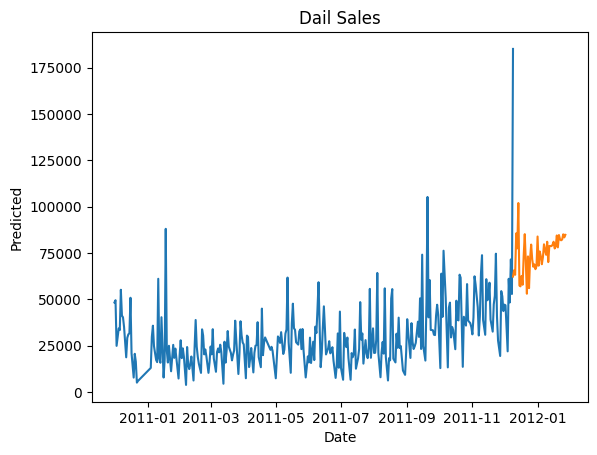

In [18]:
predictions_model = forecasting.Predictions()
predictions_model.get_sales_by_date(sales_by_date, p = 10, d = 1, q = 10, num_predictions = 50)